# Read and plot the image


(3648, 5472, 3)


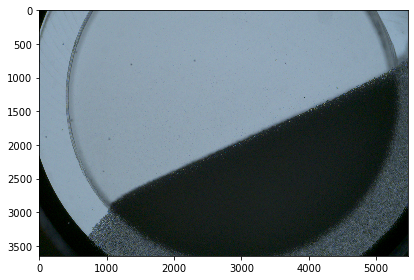

In [1]:
%matplotlib inline
from pylab import *
import skimage
from skimage import io
#read the image
directory = './Images_tobe_analyzed'
filename= 'Drum_20211015_0010.tiff'
img_input_full = io.imread(f"{directory}/{filename}", dtype=float)
#show the image
io.imshow(img_input_full)
print(img_input_full.shape)
plt.show()

# RGB to grayscale

(3648, 5472)


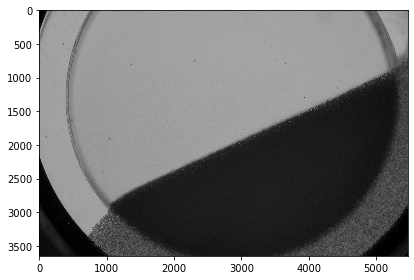

In [2]:
from skimage.color import rgb2gray

#RGB to grayscale
grayscale = rgb2gray(img_input_full)
#show the image
io.imshow(grayscale)
print(grayscale.shape)
plt.show()

# Crop the image

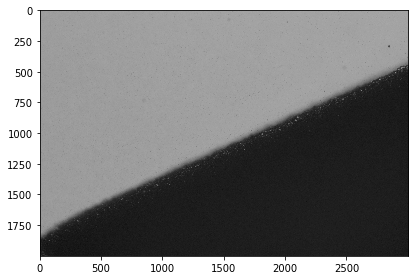

In [3]:
#crop the image
cropped = grayscale[1000:3000,1100:4100]
#show the image
io.imshow(cropped)
plt.show()

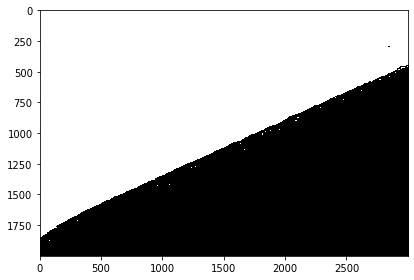

In [4]:
from skimage import filters
#from skimage.filter import threshold_otsu
global_thresh = filters.threshold_otsu(cropped)
binary_global = cropped > global_thresh


##################
#Display results
##################

io.imshow(binary_global, cmap=plt.cm.gray)
plt.show()

# Area opening and closing

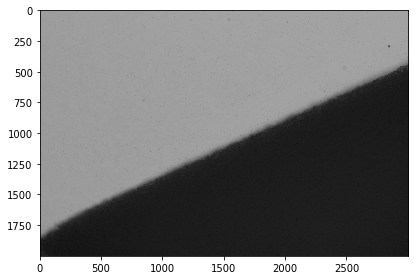

In [5]:
from skimage import morphology

#area opening of the image
#removes all bright structures of an image with a surface smaller than area_threshold
image_o= morphology.area_opening(cropped, area_threshold=512, connectivity=2)
#show the image
io.imshow(image_o)
plt.show()

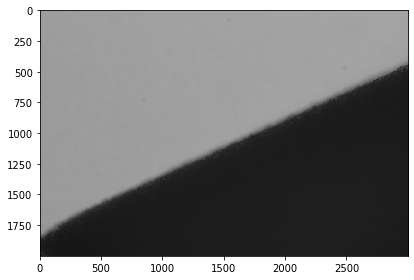

In [6]:
#area closing of the image
#removes all dark structures of an image with a surface smaller than area_threshold
image_c= morphology.area_closing(image_o, area_threshold=512, connectivity=2)
#show the image
io.imshow(image_c)
plt.show()

In [7]:
image=image_c

# Intensity plot of the image

2000 3000
0.22410090960784312 0.5671583866666667


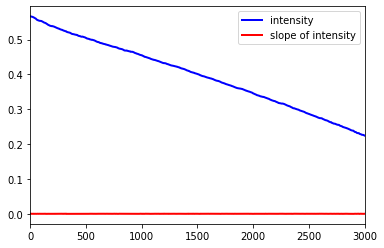

In [8]:
#finding the shape of the image
img_heigth, img_width =image.shape
print(img_heigth, img_width)
##################
#Averaging pixel intensity along the height of the image
##################
largeur=range(0, img_width, 1)
moyenne=np.zeros(np.size(largeur))
for i in largeur:
    moyenne[i]=(np.average(image[:,i],axis=0))
    #moyenne[i]=1-moyenne[i]
    
pente=np.gradient(moyenne)
minmin=min(moyenne)
maxmax=max(moyenne)
print(minmin,maxmax)

##################
#Display results
##################
fig, ax1 = plt.subplots()
ax1.plot(largeur,moyenne,'b-', linewidth=2, label='intensity')
ax1.plot(largeur,pente,'r-', linewidth=2, label='slope of intensity')
ax1.set_xlim(0, img_width)
ax1.legend()
show()

# First method: contour finding

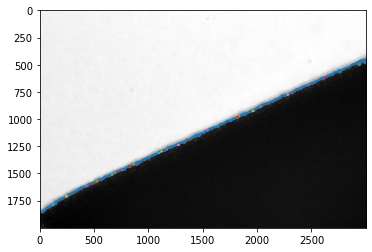

In [9]:
from skimage import measure

# Find contours at a constant value
contours = measure.find_contours(image,level=minmin,fully_connected='high')

# Display the image and plot all contours found
fig, ax = plt.subplots()

ax.imshow(image, cmap=plt.cm.gray)

for n, contour in enumerate(contours):
    ax.plot(contours[n][:, 1], contours[n][:, 0], linewidth=2)

plt.show()

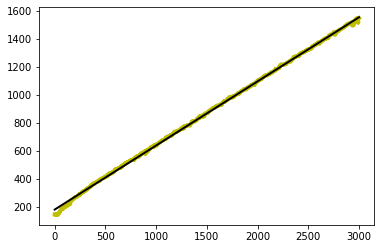

angle, standard error of angle:
24.632957541219092 0.008305180840846416


In [10]:
from scipy.stats import linregress

#select the largest contiguous contour
contour = sorted(contours, key=lambda x: len(x))[-1]

#linear least-squares regression
res= linregress(contour[:, 1], img_heigth-contour[:, 0])

fig, ax = plt.subplots()
x_fit=linspace(0,img_width,10)
ax.plot(contour[:, 1], img_heigth-contour[:, 0], 'y-',linewidth=4)
ax.plot(x_fit, res.intercept + res.slope*x_fit, 'k-', linewidth=2)
show()
print('angle, standard error of angle:')
print(rad2deg(arctan(res.slope)), rad2deg(arctan(res.stderr)))

# Second method: edge detector

/Users/elisabethguazzelli/anaconda/lib/python3.6/site-packages/skimage/io/_plugins/matplotlib_plugin.py:75: UserWarning: Low image data range; displaying image with stretched contrast.
  warn("Low image data range; displaying image with "


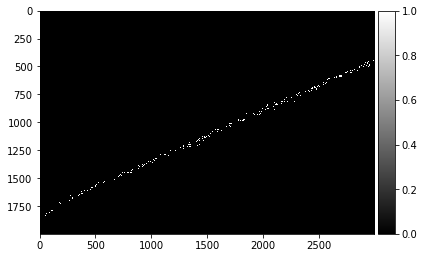

In [11]:
from skimage import filters
from skimage import feature

#edge operators
#edge = filters.scharr(image)
#edge = filters.sobel(image)

#Canny edge detector
edge = feature.canny(image, sigma=0.1)

#io.imshow(edge_scharr, cmap=plt.cm.gray)

io.imshow(edge, cmap=plt.cm.gray)
plt.show()

<string>:6: RuntimeWarning: Converting input from bool to <class 'numpy.uint8'> for compatibility.


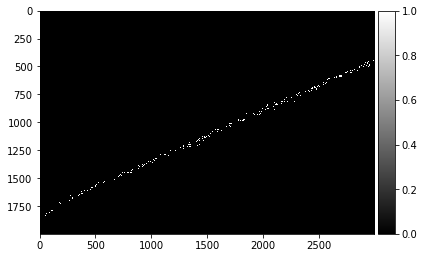

In [12]:
#image to be theresholded
image_t=edge

##################
#Otsu’s method to calculate the threshold value
#clustering-based image thresholding
#Otsu’s method calculates an “optimal” threshold
#by maximizing the variance between two classes of pixels, 
#which are separated by the threshold
#Equivalently, this threshold minimizes the intra-class variance
#see https://en.wikipedia.org/wiki/Otsu_method
##################
#from skimage.filter import threshold_otsu
global_thresh = filters.threshold_otsu(image_t)
binary_global = image_t > global_thresh


##################
#Display results
##################

io.imshow(binary_global, cmap=plt.cm.gray)
plt.show()

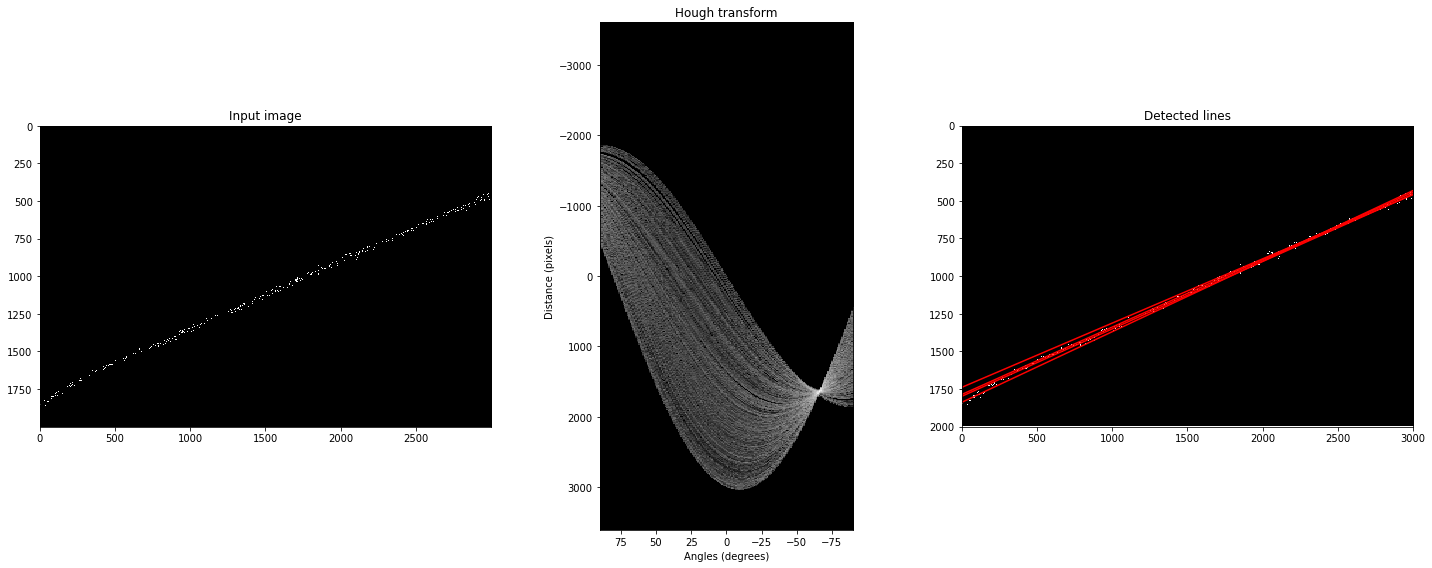

angle, standard error of angle:
24.134078212290518 0.3555285491999357


In [13]:
from skimage.transform import hough_line, hough_line_peaks

#image to be transformed
image_h=edge
#image_h=binary_global

#straight-line Hough transform
#The origin is the top left corner of the original image
#X and Y axis are horizontal and vertical edges respectively. 
h, theta, d = hough_line(image_h)

plt.figure(figsize=(20, 8))

plt.subplot(131)
plt.imshow(image_h, cmap=plt.cm.gray)
plt.title('Input image')

plt.subplot(132)
plt.imshow(np.log(1 + h),
           extent=[np.rad2deg(theta[-1]), np.rad2deg(theta[0]),
                   d[-1], d[0]],
           cmap=plt.cm.gray, aspect=1/20)
plt.title('Hough transform')
plt.xlabel('Angles (degrees)')
plt.ylabel('Distance (pixels)')

plt.subplot(133)
plt.imshow(image_h, cmap=plt.cm.gray)
rows, cols = image_h.shape
#angle made by the line with the origin 

for _, angle, dist in zip(*hough_line_peaks(h, theta, d)):
    y0 = (dist - 0 * np.cos(angle)) / np.sin(angle)
    y1 = (dist - cols * np.cos(angle)) / np.sin(angle)
    plt.plot((0, cols), (y0, y1), '-r') 
plt.axis((0, cols, rows, 0))
plt.title('Detected lines')

plt.tight_layout()
plt.show()

bestH, bestTheta, bestD = skimage.transform.hough_line_peaks(h, theta, d)

print('angle, standard error of angle:')
anglebest = 90-rad2deg(bestTheta)
print(mean(anglebest),std(anglebest)/sqrt(len(anglebest)))